In [1]:
# some necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# setting the accelerating device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We will be using",device, "for this run.")

We will be using cpu for this run.


In [3]:
# defining CNN architechture in Pytorch 
class Net(nn.Module):
    def __init__(self, classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding = 1)
        #self.conv3 = nn.Conv2d(16, 20, 3, padding = 1)
        self.adapt = nn.AdaptiveAvgPool2d(3)
        self.fc = nn.Linear(16 * 3 * 3, classes)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        x = self.adapt(x)
        x = x.view(-1, 16 * 3 * 3 )
        x = self.fc(x)
        return x

In [4]:
# data reading should be in this format for proper fucntioning of train_test_prep function
# for pytorch CNN model we will use simple pixel values.

"""    binary class pixel value ==>   binary_test.csv          binary_train.csv
       five class pixel values  ==>   five_class_test.csv      five_class_train.csv
       
       hog binary features      ==>   bin_hog_test.csv         bin_hog_train.csv
       hog five class features  ==>   five_hog_train.csv       five_hog_test.csv
"""

train_data_binary = pd.read_csv('./data/binary_train.csv')
test_data_binary = pd.read_csv('./data/binary_test.csv')

train_data_five = pd.read_csv('./data/five_class_train.csv')
test_data_five = pd.read_csv('./data/five_class_test.csv')

In [5]:
# cross checking the loaded data shapes
ft_dim = train_data_binary.shape[1] - 1  #feature dimesions
print(train_data_binary.shape)
print(train_data_five.shape)

(9938, 3073)
(24994, 3073)


In [6]:
def train_test_prep(classes):
    
    """ Give number of classed return data for training the CNN model. It is very similar to our dataloader
        in FCN but it's output dimensions are as per required by pytorch model.
    
    """
    
    # supply the proper dataframes for given classes and converting them into array
    if classes == 5:
        nptrain = np.array(train_data_five)
        nptest = np.array(test_data_five)
        
    if classes == 2:
        nptrain = np.array(train_data_binary)
        nptest = np.array(test_data_binary)

    npXtrain = nptrain[:, 0:ft_dim]                                        # getting the pixel values of train data
    npYtrain = nptrain[:, ft_dim].astype(int)                              # getting train labels
    Xtest = nptest[0:1000, 0:ft_dim]                                            # getting the pixel values fo test data
    Ytest = nptest[0:1000, ft_dim].astype(int)                                  # getting test labels
    
    
    Xval = nptest[1000:2000, 0:ft_dim]                                            # getting the pixel values fo test data
    Yval = nptest[1000:2000, ft_dim].astype(int)                                  # getting test labels
    
    
    
    
    # getting the mean and standard deviation of train pixel values for normalization
    mean = npXtrain.mean(axis = 0)
    std =  npXtrain.std(axis = 0)
     
    npXtrain = (npXtrain - mean) / std                                     # normalizing the train pixel values
    Xtest = (Xtest - mean) / std                                           # normalizing the test pixel values
    Xval = (Xval - mean) / std
    
    
    # converting Xtest to tensor and reshaping to fit pytorch model(Xtrain will be reshaped later)
    Xtest = Xtest.reshape(-1, 3, 32, 32)
    Xtest = torch.from_numpy(Xtest).to(device).float()
    Ytest = torch.from_numpy(Ytest).to(device)
    
    
    # converting Xval to tensor and reshaping to fit pytorch model(Xtrain will be reshaped later)
    Xval = Xval.reshape(-1, 3, 32, 32)
    Xval = torch.from_numpy(Xval).to(device).float()
    Yval = torch.from_numpy(Yval).to(device)


    # cross checking of shapes
    print("trainX ka shape ", npXtrain.shape)
    print("trainY ka shape ", npYtrain.shape)
    print("Xtest ka shape ", Xtest.shape)
    print("Ytest ka shape ", Ytest.shape)
    
    print("Xval ka shape ", Xval.shape)
    print("Yval ka shape ", Yval.shape)
    
    return npXtrain, npYtrain, Xtest, Ytest, Xval, Yval

In [51]:
def train(net, learning_rate, epoch, batch_size):
    """ This function trains our pytorch model for given values of hyper parameters
        Structure is pretty much same as it was in case of our FCN build from scratch
    """
  
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
    total_batches = int(len(npXtrain) / batch_size)
  
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for epochs in range(epoch):
        running_train_loss = 0.0
        running_train_accuracy = 0.0

        for i in range(total_batches):
                Xtrain = torch.from_numpy(npXtrain[i * batch_size : (i+1) * batch_size].reshape(-1, 3, 32, 32)).to(device).float()
                Ytrain = torch.from_numpy(npYtrain[i * batch_size : (i+1) * batch_size]).to(device)




                optimizer.zero_grad()
                train_outputs = net(Xtrain)


                train_loss = criterion(train_outputs, Ytrain)
                train_loss.backward()
                optimizer.step()

                _, train_predict = torch.max(train_outputs, 1)


                running_train_accuracy += torch.mean((train_predict == Ytrain).float())
                running_train_loss += train_loss



        with torch.no_grad():

          # calculating loss and accuracies of train and test data for one epoch and appending to list history
            val_outputs = net(Xval)
            epoch_val_loss = criterion(val_outputs, Yval)
            _, val_predict = torch.max(val_outputs, 1)

            epoch_val_accuracy = (100 * torch.mean((val_predict == Yval).float()))
            epoch_train_accuracy = (100 * running_train_accuracy) / total_batches
            epoch_train_loss = running_train_loss / total_batches


            train_loss_history.append(epoch_train_loss)
            train_accuracy_history.append(epoch_train_accuracy)
            val_loss_history.append(epoch_val_loss)
            val_accuracy_history.append(epoch_val_accuracy)

            if epochs % 5 == 0:
                print("======================================================")
                print("Epoch : {}".format(epochs+1))
                print("Train Loss     : {:.3f}  and Validation Loss     : {:.3f} ".format(epoch_train_loss, epoch_val_loss))
                print("Train Accuracy : {:.3f}% and Validation Accuracy : {:.3f}%".format(epoch_train_accuracy, epoch_val_accuracy))




    print('================================================ TRAINING COMPLETE ==============================================')
    
    # Test Loss and Accuracy Calculation
    test_outputs = model(Xtest)
    test_loss = criterion(test_outputs, Ytest)
    _, test_predict = torch.max(test_outputs, 1 )
    test_accuracy = (100 * torch.mean((test_predict == Ytest).float()))
    print("Test Loss : {:.3f} and Test Accuracy : {:.3f}%  ".format(test_loss, test_accuracy))
    
    
    # Loss plots
    fig = plt.figure(figsize = (15, 6))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(train_loss_history, label = 'Train Loss')
    plt.plot(val_loss_history, label = 'Validation Loss')
    plt.title('Loss Plots')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
  
    # accuracy plots
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(train_accuracy_history, label = 'Train Accuracy')
    plt.plot(val_accuracy_history, label = 'Validation Accuracy')
    plt.title("Accuracy Plots")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy in percent(%)")
    plt.legend()

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td, tr {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h3>Total count of Learnable parameters in our CNN model :</h3>
<ul>
    <b><li> Binary Classification case    : 1430 </li></b>
    <b><li> Five Class Classfication case : 1865</li></b>
</ul>

<table>
  <tr>
      <th>Layer</th>
      <th>Learnable Parameters</th>
  </tr>
  <tr>
    <td>CONV_1</td>
    <td>180</td>
  </tr>
  <tr>
    <td>CONV_2</td>
    <td>960</td>
    <tr>
    <td>FC (BINARY)</td>
    <td>290</td>
  </tr>
    <tr>
    <td>FC (FIVE CLASS)</td>
    <td>725</td>
</table>

<h1 style = 'color : Blue'>Training the model for binary class classification</h1>

trainX ka shape  (9938, 3072)
trainY ka shape  (9938,)
Xtest ka shape  torch.Size([1000, 3, 32, 32])
Ytest ka shape  torch.Size([1000])
Xval ka shape  torch.Size([1000, 3, 32, 32])
Yval ka shape  torch.Size([1000])
Epoch : 1
Train Loss     : 0.555  and Validation Loss     : 0.463 
Train Accuracy : 72.167% and Validation Accuracy : 80.000%
Epoch : 6
Train Loss     : 0.294  and Validation Loss     : 0.302 
Train Accuracy : 87.722% and Validation Accuracy : 87.600%
Epoch : 11
Train Loss     : 0.226  and Validation Loss     : 0.260 
Train Accuracy : 90.635% and Validation Accuracy : 88.500%
Epoch : 16
Train Loss     : 0.201  and Validation Loss     : 0.236 
Train Accuracy : 92.097% and Validation Accuracy : 89.300%
Epoch : 21
Train Loss     : 0.184  and Validation Loss     : 0.219 
Train Accuracy : 92.702% and Validation Accuracy : 90.200%
Epoch : 26
Train Loss     : 0.171  and Validation Loss     : 0.208 
Train Accuracy : 93.236% and Validation Accuracy : 91.500%
Epoch : 31
Train Loss    

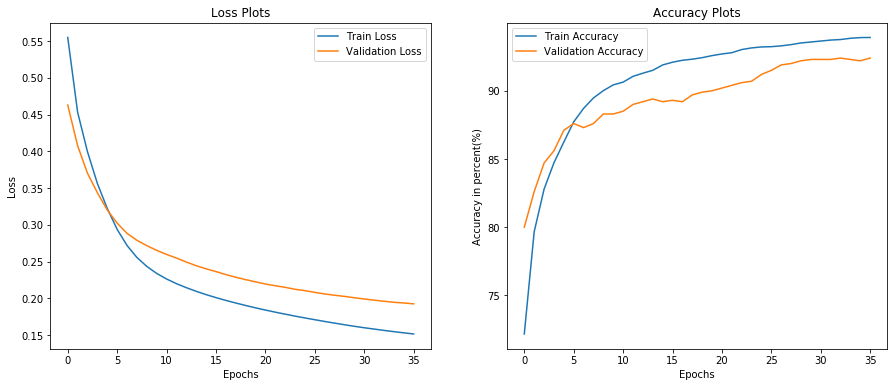

In [53]:
CLASS = 2                                                              # number of classes (2 or 5)

# Hyper parameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 36 

npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = train_test_prep(CLASS)   # getting the data

model = Net(CLASS)                                                      # getting the model
model.to(device)


# training the model
train(net = model, learning_rate = LEARNING_RATE, epoch = EPOCHS, batch_size = BATCH_SIZE)


<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h1>Results :</h1>

<table>
  <tr>
      <td><b>Learnable Parameters</b></td>
    <td>1430</td>
  </tr>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>93.91%</td>
  </tr>
   <tr>
    <td><b>Validation Accuracy</b></td>
    <td>92.40%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>92.50%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>64</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>42</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>Adam</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>0.001</td>
  </tr>
</table>
<p style = 'color:red'><b>Disclaimer : </b>results may slightly vary due to random initialization of weights. </p>

<h1 style = 'color : Blue'>Training the model for five class classification</h1>

trainX ka shape  (24994, 3072)
trainY ka shape  (24994,)
Xtest ka shape  torch.Size([1000, 3, 32, 32])
Ytest ka shape  torch.Size([1000])
Xval ka shape  torch.Size([1000, 3, 32, 32])
Yval ka shape  torch.Size([1000])
Epoch : 1
Train Loss     : 1.255  and Validation Loss     : 1.070 
Train Accuracy : 48.718% and Validation Accuracy : 55.600%
Epoch : 6
Train Loss     : 0.878  and Validation Loss     : 0.862 
Train Accuracy : 65.633% and Validation Accuracy : 65.300%
Epoch : 11
Train Loss     : 0.801  and Validation Loss     : 0.800 
Train Accuracy : 69.115% and Validation Accuracy : 69.600%
Epoch : 16
Train Loss     : 0.759  and Validation Loss     : 0.771 
Train Accuracy : 70.925% and Validation Accuracy : 70.900%
Epoch : 21
Train Loss     : 0.733  and Validation Loss     : 0.755 
Train Accuracy : 72.059% and Validation Accuracy : 71.800%
Epoch : 26
Train Loss     : 0.713  and Validation Loss     : 0.746 
Train Accuracy : 72.792% and Validation Accuracy : 72.600%
Epoch : 31
Train Loss  

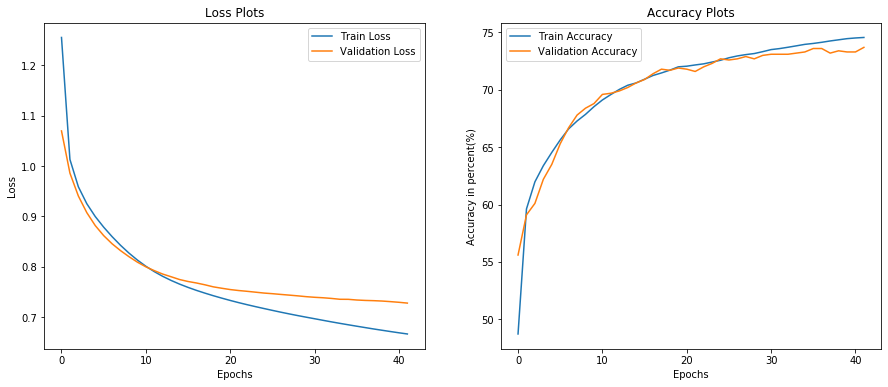

In [54]:
CLASS = 5                                                   # number of classes (2 or 5)

# Hyper parameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 42 

npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = train_test_prep(CLASS)   # getting the data

model = Net(CLASS)                                        # getting the model
model.to(device)


# training the model
train(net = model, learning_rate = LEARNING_RATE, epoch = EPOCHS, batch_size = BATCH_SIZE)

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h1>Results :</h1>

<table>
  <tr>
      <td><b>Learnable Parameters</b></td>
    <td>1865</td>
  </tr>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>74.519%</td>
  </tr>
   <tr>
    <td><b>Validation Accuracy</b></td>
    <td>73.300%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>74.000%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>64</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>42</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>Adam</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>0.001</td>
  </tr>
</table>

<p style = 'color:red'><b>Disclaimer : </b>results may slightly vary due to random initialization of weights. </p>

<h1>Conclusions :</h1>
<ul>
    <li><h3> Binary Classification </h3></li>
    <p style = 'color:blue'> CNN based model surpassed best accuracy achieved by FCN model with <b>14.14%</b> of trainable parameters. It is far better than asked 50% and 25% parameters use in CNN to beat FCN.
    </p>
    <li><h3> Five Class Classification</h3></li>
    <p style = 'color:blue'> CNN based model surpassed best accuracy achieved by FCN model with <b>18.13%</b>of trainable parameters. It is far better than asked 50% and 25% parameters use in CNN to beat FCN.
    </p>
    
</ul>